In [20]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

allowed_color = 'Green'
polylog_color = 'Black'
noyhat_color = 'Orange'
giantstep_color = 'Blue'
notallowed_color = 'Red'
processnotdefined_color = 'Purple'
sweetspot_color = 'cyan'

In [21]:
from giant_learning.poly_poly import ProjectedH3H3Overlaps
from giant_learning.gradient_descent import ProjectedGradientDescent

import numpy as np
from sklearn.preprocessing import normalize
from scipy.linalg import orth

## Changiable parameters
# mu = 1; T = 3000; gamma_prefactor = .005; seed = 2
mu = 1.75; T = 50; gamma_prefactor = .32; seed = 2
##

p = 4
k = 1
d = 2**8
noise = 1e-6
n = int(np.power(d,mu))
t = 1./np.sqrt(d)  
gamma = gamma_prefactor * n * p * np.power(d,-3/2)
ic_seed = 0

target = ProjectedH3H3Overlaps._target
activation = ProjectedH3H3Overlaps._activation
activation_derivative = ProjectedH3H3Overlaps._activation_derivative
offdiag = (False if n == 1 else True)


sim_plainsgd_test_errors = np.zeros((T+1))
sim_correlationsgd_test_errors = np.zeros((T+1))
sim_adaptivesgd_test_errors = np.zeros((T+1))
theo_plainsgd_test_errors = np.zeros((T+1))
theo_correlationsgd_test_errors = np.zeros((T+1))
theo_adaptivesgd_test_errors = np.zeros((T+1))

## Initial condition
rng = np.random.default_rng(ic_seed)
init_corr = 1/np.sqrt(d)
Wtarget = orth((normalize(rng.normal(size=(k,d)), axis=1, norm='l2')).T).T
Wtild = normalize(rng.normal(size=(p,d)), axis=1, norm='l2')
Wtild_target = np.einsum('ji,ri,rh->jh', Wtild , Wtarget ,Wtarget)
W0_orth =  normalize(Wtild - Wtild_target, axis=1, norm='l2')
W0 = (init_corr*normalize(Wtild_target,norm='l2',axis=1) + np.sqrt(1-init_corr**2)*W0_orth)
a0 = np.ones(p)

P = Wtarget @ Wtarget.T
M0 = W0 @ Wtarget.T
Q0 = W0 @ W0.T

# Assert same 
for i in range(p):
    if M0[i][0] < 0:
        W0[i] = -W0[i]
        M0[i] = -M0[i]
        Q0[i] = -Q0[i]
        Q0[:,i] = -Q0[:,i]
print(M0)
print(Q0)

gd_plain = ProjectedGradientDescent(
    target, Wtarget, n,
    activation, W0, a0, activation_derivative,
    gamma, noise, predictor_interaction=True,
    test_size = None, analytical_error= 'H3H3',
    seed = seed
)

gd_corr = ProjectedGradientDescent(
    target, Wtarget, n,
    activation, W0, a0, activation_derivative,
    gamma, noise, predictor_interaction=False,
    test_size = None, analytical_error= 'H3H3',
    seed = seed
)

gd_adaptive = ProjectedGradientDescent(
    target, Wtarget, n,
    activation, W0, a0, activation_derivative,
    gamma, noise, predictor_interaction='adaptive',
    test_size = None, analytical_error= 'H3H3',
    seed = seed
)

gd_adaptive._adaptive_percentage_threshold = 0.6

gd_plain.train(T, verbose = True)
gd_corr.train(T, verbose = True)

sim_plainsgd_test_errors = np.array(gd_plain.test_errors)
sim_correlationsgd_test_errors = np.array(gd_corr.test_errors)

def compute_mean_correlation(gd):
    Ws = np.array(gd.W_s)
    Wt = np.array(gd.W_target)
    Ms = np.einsum('tia,ja->tij', Ws, Wt)
    return np.max(Ms, axis=(1,2))
sim_plainsgd_meancorrelation = compute_mean_correlation(gd_plain)
sim_correlationsgd_meancorrelation = compute_mean_correlation(gd_corr)

[[0.0625]
 [0.0625]
 [0.0625]
 [0.0625]]
[[ 1.         -0.00600945  0.131116    0.04622446]
 [-0.00600945  1.          0.03819305 -0.07185608]
 [ 0.131116    0.03819305  1.          0.06881447]
 [ 0.04622446 -0.07185608  0.06881447  1.        ]]


100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


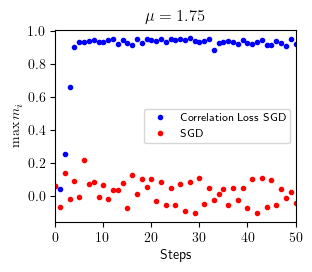

In [22]:
fig, ax = plt.subplots(1,1,figsize=(3.1,2.5))

Ts = np.arange(T+1)
plot_every = 1

# Test error
R0 = 1.0
# ax.plot(sim_correlationsgd_test_errors/R0, label=f'Correlation Loss SGD', marker='', ls='-', color='blue')
# ax.plot(sim_plainsgd_test_errors/R0, label=f'SGD', marker='', ls='-', color='red')

# Correlation M
ax.plot(Ts[::plot_every], sim_correlationsgd_meancorrelation[::plot_every], label=f'Correlation Loss SGD', marker='.', ls='', color='blue')
ax.plot(Ts[::plot_every], sim_plainsgd_meancorrelation[::plot_every], label=f'SGD', marker='.', ls='', color='red')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Steps')
ax.set_ylabel(r'$\max{m_i}$')
ax.set_xlim([0,T])
ax.set_title(f'$\\mu={mu}$')
# ax.set_ylim([2,5])
ax.legend(fontsize=8)

plt.savefig(f'figures/singleidexteacher_widestudent_mu{mu}.pdf', bbox_inches = 'tight')

